# Binary `{calc, mass}` classification labels

Create .csv file for labels for each unique mammogram identifier.

In [127]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from classification_models.keras import Classifiers

ImportError: cannot import name 'get_submodules_from_kwargs' from 'classification_models' (/Users/cleonwong/Desktop/Code/mammogram-cv/env/lib/python3.8/site-packages/classification_models/__init__.py)

In [2]:
all_df = pd.read_csv("../data/csv/mass_calc_all.csv")

all_df.head()

,identifier,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,calc_type,calc_distribution,assessment,pathology,subtlety,mass_shape,mass_margins
0,P_00005_RIGHT_CC,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,NaN,NaN
1,P_00005_RIGHT_MLO,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,NaN,NaN
2,P_00007_LEFT_CC,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,NaN,NaN
3,P_00007_LEFT_MLO,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,NaN,NaN
4,P_00008_LEFT_CC,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,NaN,NaN


In [14]:
# Get identifiers that have both calcification and mass abnormalities.
# --------------------------------------------------------------------

# Create dictionary of identifiers.
iden_list = list(all_df["identifier"].unique())
iden_dict = dict((iden, []) for iden in iden_list)

# Loop through all_df and get calcification or mass type.
for row in all_df.itertuples():
    
    iden = row.identifier
    ab_type = row.abnormality_type
    
    if ab_type not in iden_dict[iden]:
        iden_dict[iden].append(ab_type)
    
# Check for identifiers with >1 type.
both_iden = []
for k, v in iden_dict.items():
    
    if len(v) > 1:
        both_iden.append(k)
        
print(both_iden)

['P_00016_LEFT_CC', 'P_00016_LEFT_MLO', 'P_00034_RIGHT_CC', 'P_00034_RIGHT_MLO', 'P_00106_RIGHT_CC', 'P_00106_RIGHT_MLO', 'P_00208_RIGHT_MLO', 'P_00224_LEFT_CC', 'P_00224_LEFT_MLO', 'P_00385_RIGHT_CC', 'P_00385_RIGHT_MLO', 'P_00510_LEFT_CC', 'P_00510_LEFT_MLO', 'P_00522_RIGHT_MLO', 'P_00539_RIGHT_CC', 'P_00539_RIGHT_MLO', 'P_00573_RIGHT_MLO', 'P_00591_RIGHT_MLO', 'P_00601_LEFT_CC', 'P_00601_LEFT_MLO', 'P_00652_LEFT_CC', 'P_00666_RIGHT_CC', 'P_00666_RIGHT_MLO', 'P_00673_RIGHT_MLO', 'P_00710_RIGHT_CC', 'P_00710_RIGHT_MLO', 'P_00734_RIGHT_MLO', 'P_00814_LEFT_CC', 'P_00814_LEFT_MLO', 'P_00847_LEFT_MLO', 'P_00924_RIGHT_CC', 'P_00969_LEFT_CC', 'P_00969_LEFT_MLO', 'P_01084_LEFT_CC', 'P_01084_LEFT_MLO', 'P_01262_RIGHT_CC', 'P_01262_RIGHT_MLO', 'P_01274_RIGHT_MLO', 'P_01297_LEFT_CC', 'P_01297_LEFT_MLO', 'P_01365_LEFT_CC', 'P_01454_LEFT_MLO', 'P_01467_RIGHT_CC', 'P_01517_LEFT_MLO', 'P_01567_LEFT_MLO', 'P_01573_RIGHT_CC', 'P_01573_RIGHT_MLO', 'P_01605_LEFT_CC', 'P_01725_RIGHT_CC', 'P_01725_RIGHT_

In [15]:
# Remove identifiers with both calc and mass
# ------------------------------------------

for iden in both_iden:
    del iden_dict[iden]

In [31]:
# Create datafrom from iden_dict
# ------------------------------

calc_labels_df = pd.DataFrame.from_dict(data=iden_dict, orient="index", columns=["labels"])
calc_labels_df.reset_index(level=0, inplace=True)
calc_labels_df.rename(columns={"index":"identifier"}, inplace=True)

# Save
calc_labels_df.to_csv("../data/csv/calc_labels_all.csv", index=False)

# One hot encode - 1 = calcification, 0 = mass
calc_ohe_df = pd.get_dummies(calc_labels_df["labels"])
calc_ohe_df.drop(columns=["mass"], inplace=True)

# Save
calc_ohe_df.to_csv("../data/csv/calc_ohe_all.csv", index=False)

In [32]:
# Create labels as tensorflow dataset
# -----------------------------------

y = np.asarray(calc_ohe_df["calcification"])
y

array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)

In [38]:
base_model = keras.applications.ResNet50(
                include_top=False,
                weights="imagenet",
                input_shape=(224, 224, 3),
            )

In [39]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [40]:
base_model.output

<tf.Tensor 'conv5_block3_out/Relu_1:0' shape=(None, 7, 7, 2048) dtype=float32>

## Create classification train and test dataset

In [129]:
top = "../data/preprocessed/Classification/all_classification"
extension = ".png"

# 1. Get lists of calc and mass filenames
# =======================================

mass = []
calc = []

for (curdir, dirs, files) in os.walk(top=top, topdown=False):

    dirs.sort()
    files.sort()

    for f in files:

        if f.endswith(extension):
            
            if "mass" in f.lower():
                mass.append(f)
            elif "calc" in f.lower():
                calc.append(f)

In [130]:
# 2. Random split paths into train and valid
# ==========================================

val_split = 0.2
mass_val_count = round(val_split * len(mass))
calc_val_count = round(val_split * len(calc))

mass_val = random.sample(mass, mass_val_count)
mass_train = [m for m in mass if m not in mass_val]

calc_val = random.sample(calc, calc_val_count)
calc_train = [c for c in calc if c not in calc_val]

val = mass_val + calc_val
train = mass_train + calc_train

random.shuffle(val)
random.shuffle(train)

In [131]:
# 3. Create train and test dataframe with labels
# ==============================================

val_df = pd.DataFrame(data=val, columns=["filename"])
val_df["label"] = val_df["filename"].apply(lambda x: "calc" if "Calc" in x else "mass")
val_df["calc"] = val_df["filename"].apply(lambda x: 1 if "Calc" in x else 0)
val_df["mass"] = val_df["filename"].apply(lambda x: 1 if "Mass" in x else 0)

train_df = pd.DataFrame(data=train, columns=["filename"])
train_df["label"] = train_df["filename"].apply(lambda x: "calc" if "Calc" in x else "mass")
train_df["calc"] = train_df["filename"].apply(lambda x: 1 if "Calc" in x else 0)
train_df["mass"] = train_df["filename"].apply(lambda x: 1 if "Mass" in x else 0)

In [133]:
# 4. Use ImageDataGenerator to create train and val datasets
# ==========================================================

batch_size = 10
target_size = (224, 224)

# Define data generator
train_gen = ImageDataGenerator(rescale=1./255,
                               horizontal_flip=True,
                               vertical_flip=True,
                               brightness_range=(0.6, 1.3)
)

val_gen = ImageDataGenerator(rescale = 1./255)

# Get the data
train_data = train_gen.flow_from_dataframe(dataframe = train_df, 
                                           directory = top, 
                                           x_col = "filename", 
                                           y_col = "label",
                                           batch_size = batch_size,
                                           color_mode = "rgb",
                                           class_mode = "binary",
                                           target_size = target_size,
                                           shuffle = True,
                                           seed = 42)

val_data = val_gen.flow_from_dataframe(dataframe = val_df, 
                                         directory = top,
                                         x_col = "filename", 
                                         y_col = "label",
                                         batch_size = batch_size,
                                         color_mode = "rgb",
                                         class_mode="binary",
                                         target_size = target_size,
                                         shuffle = True,
                                         seed = 42)

Found 2369 validated image filenames belonging to 2 classes.
Found 592 validated image filenames belonging to 2 classes.


In [134]:
train_data.class_indices


{'calc': 0, 'mass': 1}

In [136]:
# To check images and labels from the data generator
imgs, lbl = next(iter(train_data))

print(lbl)

[0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]


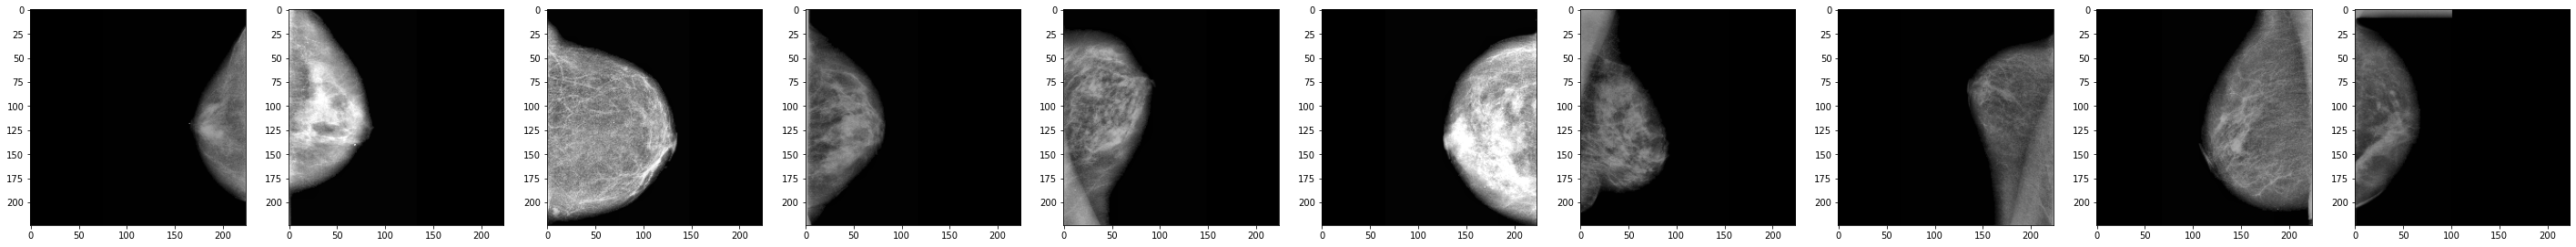

In [103]:
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(50, 5))

for i in range(10):
    ax[i].imshow(imgs[i], cmap="gray")

In [148]:
base_model = keras.applications.VGG16(
                include_top=False,
                weights="imagenet",
                input_shape=(224, 224, 3)
            )

x = base_model.output

# Add Global Average Pooling layer.
x = keras.layers.GlobalAveragePooling2D()(x)

# Add FC layer having 1024 neurons.
x = keras.layers.Dense(
    units=1024, activation="relu"
)(x)

# Add FC output layer for final classification.
final_x = keras.layers.Dense(
    units=1,
    activation="sigmoid",
)(x)

# Create ResNet50 model.
VGG16_model = keras.Model(inputs=base_model.input, outputs=final_x)

# Freeze layers of base model.
for layer in base_model.layers:
    layer.trainable = False

In [149]:
VGG16_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [141]:
base_model.output

<tf.Tensor 'block5_pool/MaxPool_1:0' shape=(None, 7, 7, 512) dtype=float32>

In [168]:
arr = np.zeros(shape=(21, 7))
arr

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [169]:
def centerCrop(img):

    h, w = img.shape

    # If cropping is required...
    if h != w:

        # Take the shorter side as the square length.
        if w < h: # Vertical rectangle, use w as square length.
            start_w = 0
            end_w = w
            start_h = h//2 - w//2
            end_h = start_h + w

        elif h < w: # Horizontal rectangle, use h as square length.
            start_h = 0
            end_h = h
            start_w = w//2 - h//2
            end_w = start_w + h

        # Crop.
        sq_img = img[start_h:end_h, start_w:end_w]

        return sq_img

    # If padding is not required...
    elif nrows == ncols:

        # Return original image.
        return img

In [170]:
crop = centerCrop(img=arr)

In [171]:
crop.shape

(7, 7)